In [1]:
# load stuff:
import scipy.optimize as so
import datetime as dt


from dataload_helper import Dataset
from dataeval_helper import *  # load here also numpy, scipy,...
from global_params import *

#import cartopy.crs as ccrs

In [2]:
#load Datasets
#SETNAME="MERRA"
SETNAME="MERRA2"
#SETNAME="JRA-55"
#Global Params
if SETNAME=="MERRA":
    FILES="../Data/Merra_inst3_3d_asm_Cp_1979-2016/instM_3d_asm_Cp_197901_201601.nc"
    RESLOC = '../Results/'
    RESLOC_SPECIFIC = 'MERRA_T/'
    DATALOC_SPECIFIC = 'Merra_inst3_3d_asm_Cp_1979-2016/'
    DATALOC = '../Data/' + DATALOC_SPECIFIC
elif SETNAME=="MERRA2":
    FILES="../../../../../../work/mh0066/m301053/Data/MERRA2_instM_3d_asm_Np_PS,RH,T/MERRA2_*"
    RESLOC = '../Results/'  #'../DemoPlots4Pres/'
    RESLOC_SPECIFIC = 'MERRA2_T/'
    DATALOC_SPECIFIC = 'MERRA2_instM_3d_asm_Np_PS,RH,T/'
    DATALOC = '../../../../../../work/mh0066/m301053/Data/' + DATALOC_SPECIFIC
elif SETNAME=="JRA-55":
    FILES="../../../../../../work/mh0066/m301053/Data/JRA-55_Monthly_1.25_Deg_isobaric/anl*"
    RESLOC = '../Results/' #'../DemoPlots4Pres/'#
    RESLOC_SPECIFIC = 'JRA-55_T/'
    DATALOC_SPECIFIC = 'JRA-55_Monthly_1.25_Deg_isobaric/'
    DATALOC = '../../../../../../work/mh0066/m301053/Data/' + DATALOC_SPECIFIC
else:
    raise Exception("Sorry, notexisting Setname")
#What parts of the Notebook should run?
TOPOANALYSIS=False

MASKELEVATION=False
SURFACEVALUES=False

GLOBALTEMPDIST=True
GLOBALTEMPDISTCOMPARE=False

VERTICALPROFILES=True
VERTICALPROFILESCOMPARE=False

TEMPTRENDANALYSIS=False

#Times for analysis
t1_start='1980-01-01'
t1_end='1989-12-01'
t2_start='2010-01-01'
t2_end='2019-12-01'

In [3]:
DS = Dataset(files=FILES, setname = SETNAME, dataloc = DATALOC)


Loading full dataset JRA-55
[########################################] | 100% Completed | 15.10 s
<xarray.Dataset>
Dimensions:  (time: 504, lon: 288, lat: 145, p: 37)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 7.0 5.0 3.0 2.0 1.0
Data variables:
    RH       (time, p, lat, lon) float32 dask.array<chunksize=(12, 37, 145, 288), meta=np.ndarray>
    T        (time, p, lat, lon) float32 dask.array<chunksize=(12, 37, 145, 288), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Jul 03 15:11:16 2023: cdo -f nc --eccodes copy anl_p125...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...


In [4]:
if MASKELEVATION==True:
    DS_2D = Dataset(files='../../../../../../work/mh0066/m301053/Data/JRA-55_Monthly_1.25_Deg_surface/*pres.nc', setname = 'JRA-55_2D', dataloc = '../../../../../../work/mh0066/m301053/Data/JRA-55_Monthly_1.25_Deg_surface/')
    DS.ds = elevation2nan( DS.ds, DS_2D.ds )
    print(DS.ds)

In [5]:
if SURFACEVALUES==True:
    DS.init_surfacevals()

In [6]:
# =======================================================================
#Initilize topography analysis
if TOPOANALYSIS==True:
    TOPO = Dataset(files="../../../../../../work/mh0066/m301053/Data/Topo/topo_r720x360.nc", setname = 'TOPO', dataloc = '../../../../../../work/mh0066/m301053/Data/Topo/')
    TOPO.land_mask = xr.where(TOPO.ds.topo >= 0.0, True, False)
    
    # Reindex the land mask to match the climate data grid
    TOPO.land_mask_reindexed = TOPO.land_mask.reindex_like(DS.ds, method='nearest')
    print(TOPO.land_mask_reindexed)
    #TOPO.ds.where(TOPO.land_mask_reindexed==False).topo.plot(ax=ax, transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_elevation,cbar_kwargs= cbar_kwargs) for ocean


In [7]:
#Interpolation
#DS.ds_surface_interp=DS.ds_surface.interp(,axis='p')
#DS.ds.T.where(DS.ds.p == DS.ds.T.notnull().idxmax(dim="p")).max("p").isel(time=0).plot()

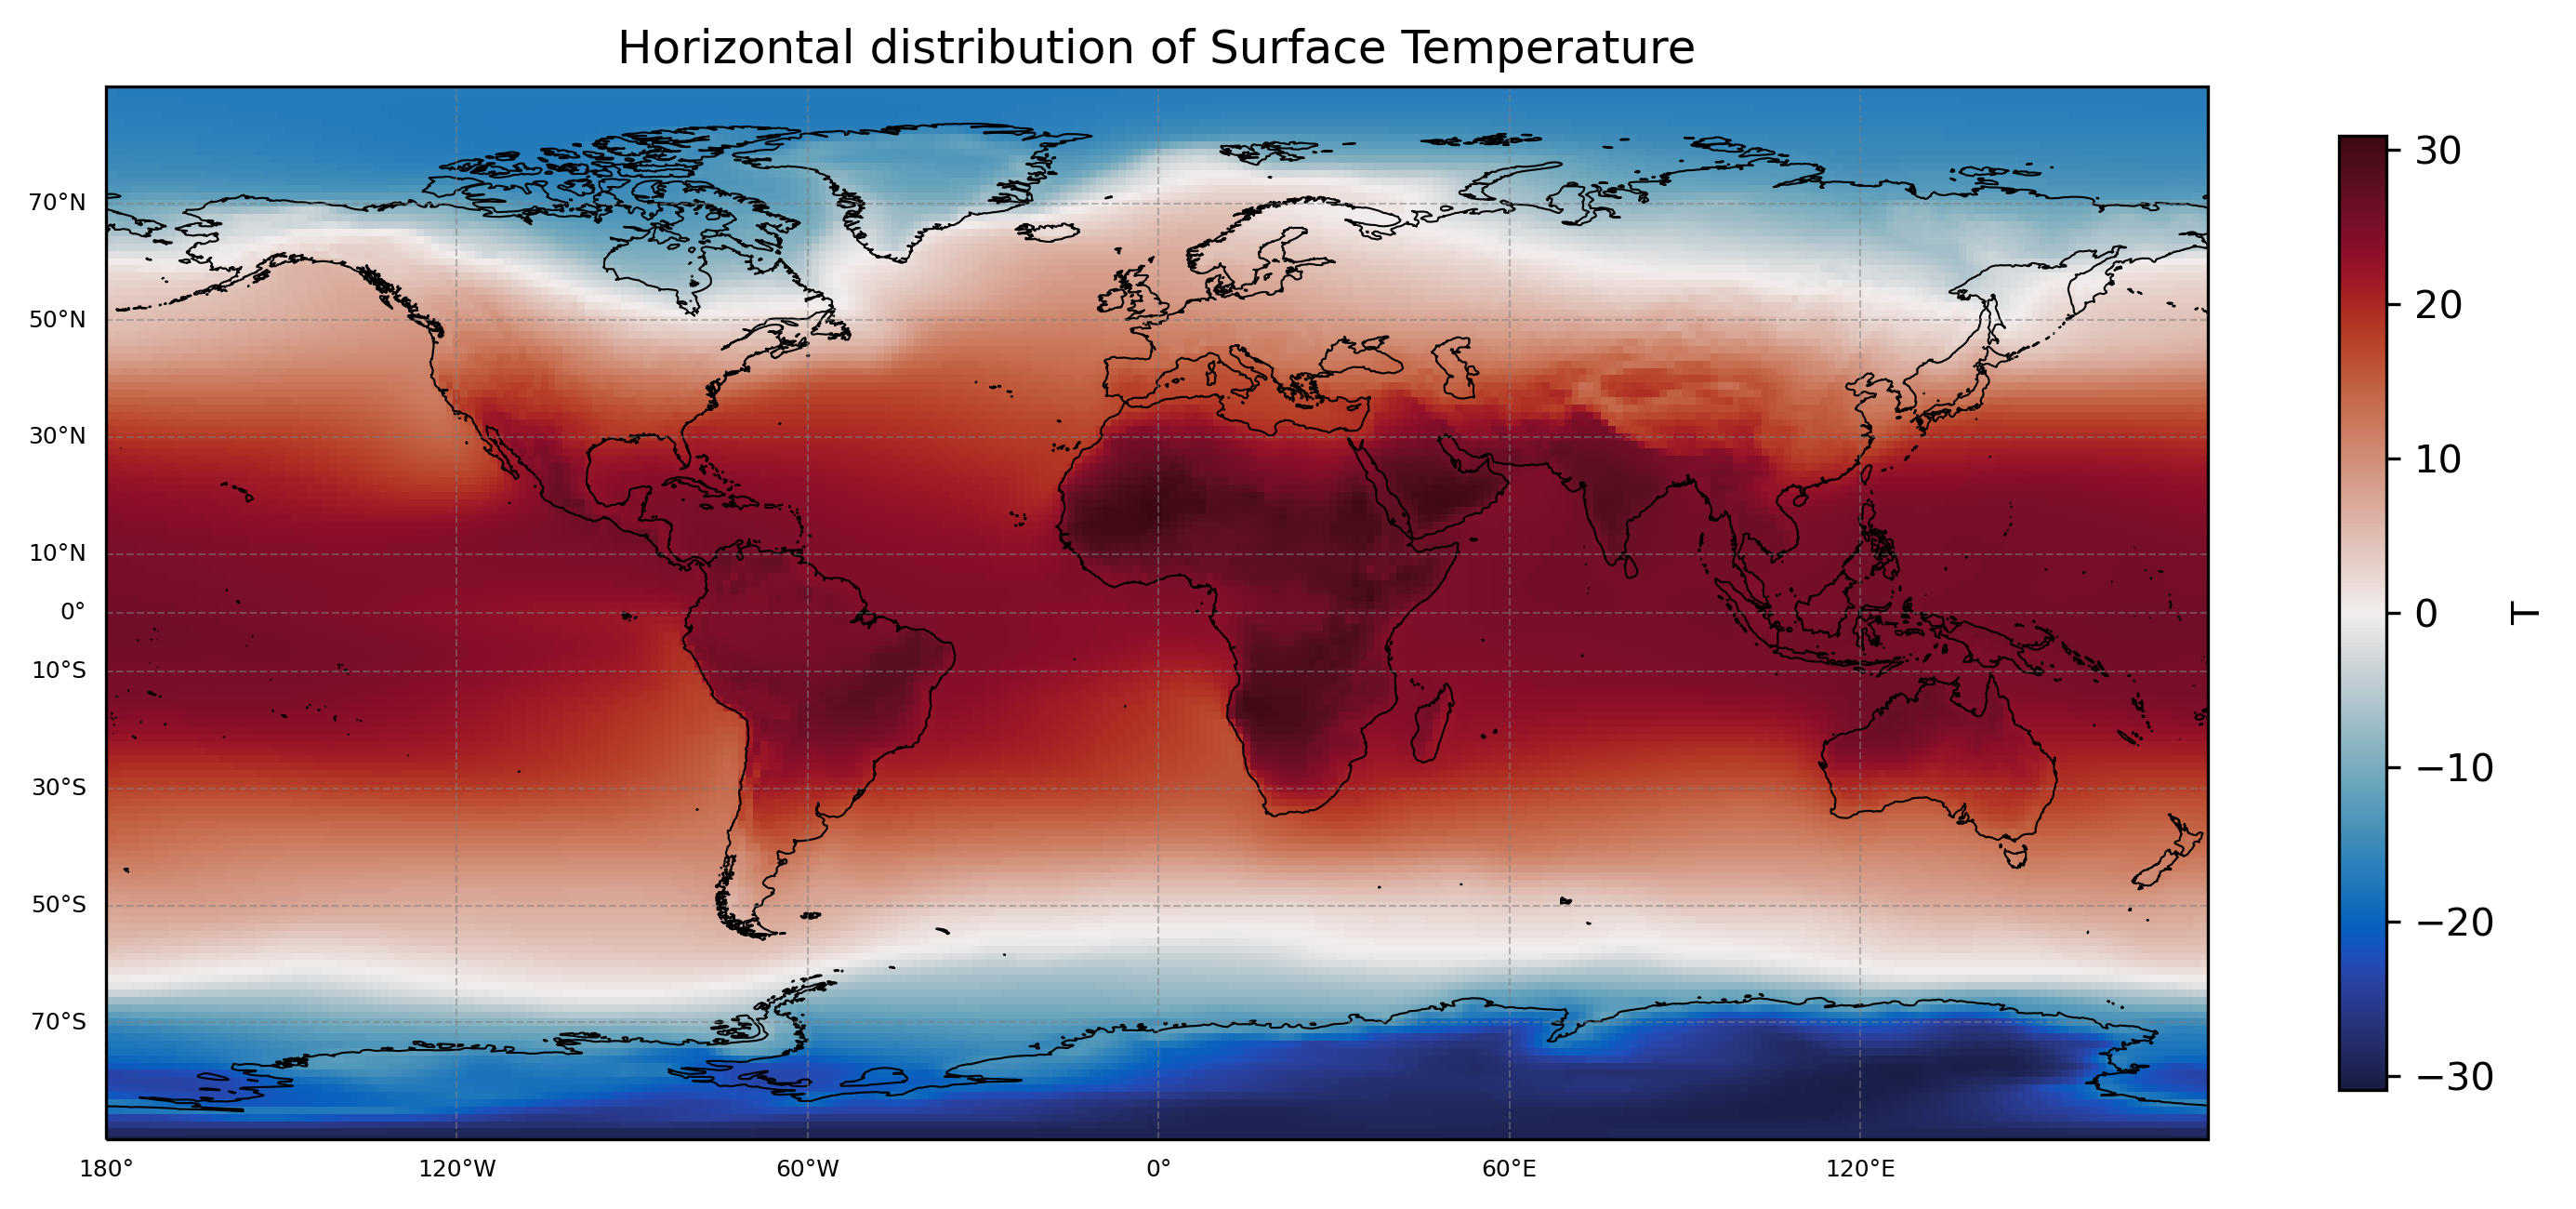

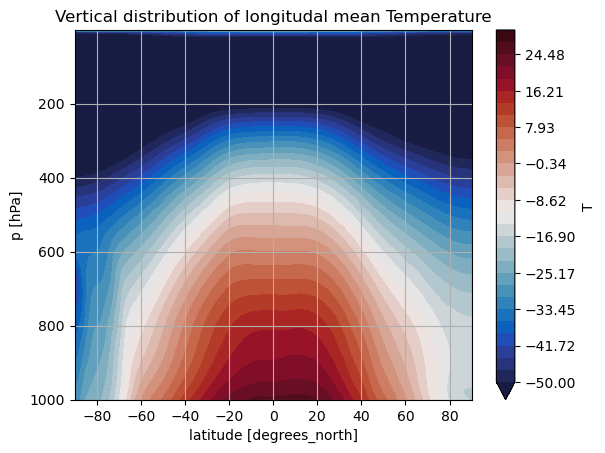

In [8]:

t1=t1_start
t2=t1_end
l1=-90
l2=90


# =======================================================================
#Temp overview
if GLOBALTEMPDIST==True:

    # Plot T @ Sealevel and mean over timerange and Lat zone
    
    fig, ax, gl, cbar_kwargs = create_empty_2d_map()#projection=ccrs.Robinson()
    
    t1=t1_start
    t2=t1_end
    l1=-90
    l2=90
    cmap = plt.get_cmap(cmocean.cm.balance, 20)
    if SURFACEVALUES==True:
        time_mean(get_timeframe(get_lat_zone(DS.ds_surface.T,l1,l2),t1,t2)).plot.contourf(ax=ax, levels=20, transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_T,cbar_kwargs= cbar_kwargs)
    else:
        time_mean(get_timeframe(get_lat_zone(get_sea_level(DS.ds.T),l1,l2),t1,t2)).plot(ax=ax, transform=ccrs.PlateCarree(),x='lon',y='lat',cmap=cmap_T,cbar_kwargs= cbar_kwargs)
    ax.set_title('Horizontal distribution of Surface Temperature')
    plt.tight_layout()
    plt.savefig(RESLOC+RESLOC_SPECIFIC+'global_Temp_Distribution_horizontal.png',dpi=400)
    plt.show()
    
    
    # Vertical Temp Plot with contours
    
    fig = plt.figure()
    time_mean(get_timeframe(lon_mean(DS.ds.T),t1,t2)).plot.contourf(yincrease=False,vmin=-50, vmax=30, levels=30, x='lat',y='p',cmap=cmap_T)
    plt.title('Vertical distribution of longitudal mean Temperature')
    plt.savefig(RESLOC+RESLOC_SPECIFIC+'global_Temp_Distribution_vertical.png',dpi=400)
    plt.grid()
    plt.show()
    

In [9]:
# =======================================================================
# Compare Temp in different time periods:
if GLOBALTEMPDISTCOMPARE==True:
    T1 = lon_mean(time_mean( DS.ds.T.sel(time=slice(t1_start,t1_end)) ))
    T2 = lon_mean(time_mean( DS.ds.T.sel(time=slice(t2_start,t2_end)) ))

    T_diff=(T2-T1)
    

    
    #Plot difference with contours
    fig, ax = plt.subplots()
    
    T_diff.plot.contourf(yincrease=False,vmin=-2.5, vmax=2.5, levels=30,cmap=cmap_T)
    ax.set_title('Change in Temperature comparing \n ' +t1_start+ ' to ' + t1_end + ' and period '+ t2_start+ ' to ' + t2_end)
    ax.set_ylim(top=TOP_LIM4PLOT)
    ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(RESLOC+RESLOC_SPECIFIC+'absolute_T_change_2.png',dpi=400)
    plt.show()

-90 -85
-85 -70
-50 -30
-10 10
30 50
70 90


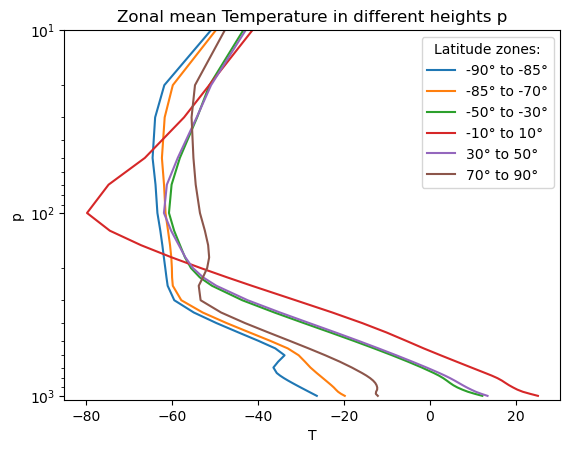

In [10]:
# =======================================================================
#Temp vertical profiles in zones in mean over timeframe

if VERTICALPROFILES==True:
    zones=ZONES_Flo

    fig, ax = plt.subplots()


    for i in range(0,int(0.5*len(zones))):
        l1 = zones[2*i]
        l2 = zones[2*i+1]
        print(l1,l2)
        #print(K2Deg(time_mean(get_timeframe(lat_mean(get_lat_zone(lon_mean(DS.ds).T,l1,l2)),t1,t2))))
        #time_mean(get_timeframe(lat_mean(get_lat_zone(lon_mean(DS.ds).T,l1,l2)),t1,t2)).plot.line(y='p',yincrease=False, label = str(l1)+'° to '+str(l2)+'°')
        get_timeframe(lat_mean(get_lat_zone(lon_mean(DS.ds).T,l1,l2)),'1980-01-01','1988-01-01').mean('time').plot.line(y='p',yincrease=False, label = str(l1)+'° to '+str(l2)+'°')
        
    ax.set_ylim(top=TOP_LIM4PLOT)
    ax.set_yscale('log')
    ax.set_title('Zonal mean Temperature in different heights p')
    ax.legend(title = 'Latitude zones:')
    plt.savefig(RESLOC+RESLOC_SPECIFIC+'vertical_Temp_profiles.png',dpi=400)
    plt.show()



In [11]:
def get_min_temp(ds):
    return ds['T'].min(dim='p', keep_attrs=True)

def get_p_below_temp_inv(ds):
    return ds['T'].idxmin(dim='p', keep_attrs=True)

#def get_p_below_temp_inv(ds):
#    min_idx = ds['T'].idxmin(dim='p', keep_attrs=True)
#    return ds.isel(p=min_idx)


def extract_below_temp_inv(ds):
    with ProgressBar():
             ds_below_min = dask.compute( ds.where(ds.p >= ds['T'].idxmin(dim='p', keep_attrs=True)  )   )[0]   # ds.T.notnull().idxmax(dim="p")).max("p"))[0] 
    return ds_below_min


In [ ]:
extract_below_temp_inv(DS.ds.mean("time")).mean(("lon")).T.plot.contourf(yincrease=False,vmin=-80, vmax=30, levels=30, x='lat',y='p',cmap=cmap_T)

[#################################       ] | 83% Completed | 61.33 ss

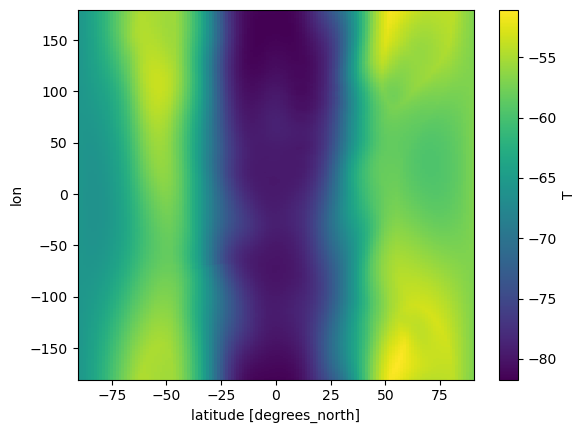

In [13]:
get_min_temp(DS.ds.mean("time")).T.plot()

In [14]:
get_p_below_temp_inv(DS.ds)

<xarray.DataArray 'p' (time: 504, lat: 145, lon: 288)>
dask.array<where, shape=(504, 145, 288), dtype=float64, chunksize=(12, 145, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-12-01
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
Attributes:
    units:    deg C

In [15]:
def get_gradient(ds):
    

SyntaxError: incomplete input (126426873.py, line 2)

In [ ]:
# =======================================================================
#Temp vertical profiles in zones in mean over timeframe

if VERTICALPROFILESCOMPARE==True:
    zones=ZONES_Helene
    
    fig, ax = plt.subplots()


    for i in range(0,int(0.5*len(zones))):
        l1 = zones[2*i]
        l2 = zones[2*i+1]
        print(l1,l2)
        T_diff =time_mean(get_timeframe(lat_mean(get_lat_zone(lon_mean(DS.ds).T,l1,l2)),t2_start,t2_end))-time_mean(get_timeframe(lat_mean(get_lat_zone(lon_mean(DS.ds).T,l1,l2)),t1_start,t1_end))
        T_diff.plot.line(y='p',yincrease=False, label = str(l1)+'° to '+str(l2)+'°')
    
    ax.set_ylim(top=TOP_LIM4PLOT)
    ax.set_yscale('log')
    ax.set_title('Zonal mean Temperature in different heights p comparing \n ' +t1_start+ ' to ' + t1_end + ' and period '+ t2_start+ ' to ' + t2_end)
    ax.legend(title = 'Latitude zones:')
    plt.savefig(RESLOC+RESLOC_SPECIFIC+'vertical_Temp_profiles_change.png',dpi=400)
    plt.show()

In [ ]:

# =======================================================================
# Temp Trend in different latitudes
if TEMPTRENDANALYSIS==True:
    zones=ZONES_Helene_double
    
    def lin(x,a,b):
        return a*x + b
    
    
    
    fig = plt.figure()

    for i in range(0,int(0.5*len(zones))):
        l1 = zones[2*i]
        l2 = zones[2*i+1]
        print(l1,l2)
        Temp=get_double_lat_zone(DS.ds_surface.T,l2,l1).mean(("lon","lat"))
        Temp=Temp-Temp.mean("time").to_numpy()
        #print(get_timepoint(Temp,-1).to_numpy())
        #Temp=Temp.where(Temp.T.compute().notnull(), drop=True)
        Temp.attrs = DS.ds.T.attrs
        time_raw=Temp.time
        time_mon=time_raw.dt.month+12*time_raw.dt.year
        #print(Temp.T.to_numpy())
        lin_para,dlin_para=so.curve_fit(lin,time_mon.to_numpy(),Temp.T.to_numpy())
        dlin_para=np.sqrt(dlin_para.diagonal())
        
        decimals=2
        
        plt.plot(
            time_raw.to_numpy()[::12],
            year_mean(Temp).to_numpy(),
            label = f"[{l1}-{l2}]°",
            linewidth=0.8,
        )
        
        
        plt.plot(
            time_raw.to_numpy(),
            lin(time_mon.to_numpy(),*lin_para),
            linestyle='dotted',
            label=f"Fit: grad= {12*lin_para[0]:.3f} +- {12*dlin_para[0]:.3f} K/y",
        )
        
        plt.legend(fontsize="x-small", loc ="lower right")
        plt.savefig("Temp_Timeseries.png")
        
        del Temp,time_raw,time_mon
        
    

In [ ]:
# =======================================================================
# Temp Trend in different latitudes
if TEMPTRENDANALYSIS==True:
    zones=[[0,10]]
    
    heights=[[1000,950],[700,650],[500,450]]
    
    def lin(x,a,b):
        return a*x + b
    
    
    
    fig, ax = plt.subplots()

    for i in zones:
        
        
        for j in heights:
        
            Temp=get_double_lat_zone(DS.ds.T.sel(p=slice(j[0],j[1])),i[0],i[1]).mean(("lon","lat","p"))
            Temp=Temp-Temp.mean("time").to_numpy()

            Temp.attrs = DS.ds.T.attrs
            time_raw=Temp.time
            time_mon=time_raw.dt.month+12*time_raw.dt.year


            lin_para,dlin_para=so.curve_fit(lin,time_mon.to_numpy(),Temp.T.to_numpy())
            dlin_para=np.sqrt(dlin_para.diagonal())

            decimals=2


            lh, = ax.plot(
                time_raw.to_numpy()[::12],
                year_mean(Temp).to_numpy(), 
                label=f"[{i[0]}-{i[1]}]°, [{j[0]}-{j[1]}]hPa",
                linewidth=0.8,
            )

            ax.plot(
                time_raw.to_numpy(),
                lin(time_mon.to_numpy(),*lin_para),
                linestyle='dotted',
                label=f"Fit: grad= {12*lin_para[0]:.3f} +- {12*dlin_para[0]:.3f} K/y",
                color=lh.get_color(),
            )

        ax.legend(fontsize="x-small", loc ="lower right")
        fig.savefig("Temp_Timeseries.png")
        
        # del Temp,time_raw,time_mon
        